**Install requirements**

In [0]:
!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision>=0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 634kB 2.9MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110320 sha256=a9356a06fa7aaee482ac8bacc34d5f074a920d9cf101a0bf6abca609cc282340
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built Pillow-SIMD


**Import LFWCrop Dataset from GitHub**

In [0]:
import os
!rm -rf lfwcrop
!rm -rf output
!git clone https://github.com/Antonio210696/LFWCrop_dataset_pytorch lfwcrop
os.chdir('lfwcrop')
!mv lfwcrop2.py ..
os.chdir('/content')

Cloning into 'lfwcrop'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 13361 (delta 45), reused 51 (delta 21), pack-reused 13286
Receiving objects: 100% (13361/13361), 156.27 MiB | 40.54 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (13283/13283), done.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Import libraries**

In [0]:
import os
import numpy as np  
import time
import random

from lfwcrop2 import LFWCrop

import torch 
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import datasets 
from torchvision.datasets.utils import download_file_from_google_drive
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

import torch.nn as nn
import torch.nn.functional as F 
import torchvision.utils as vutils


**Useful Classes**

In [0]:
# reshape layer
class Reshape(nn.Module):
  def __init__(self, *args):
    super(Reshape, self).__init__()
    self.shape = args
  
  def forward(self, x):
    return x.view(self.shape)


class ListModule(object):
  def __init__(self, module, prefix, *args):
    self.module = module
    self.prefix = prefix    # prefix of the name of the list of modules
    self.num_module = 0     # keeps count of the number of modules

    # to start with predefined modules
    for new_module in args:
      self.append(new_module)

  # to append new modules
  def append(self, new_module):
    if not isinstance(new_module, nn.Module):
      raise ValueError('Not a Module')
    else:
      self.module.add_module(self.prefix + str(self.num_module), new_module)
      self.num_module += 1
  
  def __len__(self):
    return self.num_module
  
  def __getitem__(self, i):
    if i < 0 or i >= self.num_module:
      raise IndexError('Out of bound')
    return getattr(self.module, self.prefix + str(i))


class MaxoutUnit(nn.Module):
  def __init__(self, num_units=500):
    super(MaxoutUnit, self).__init__()
    self.fc1_list = ListModule(self, "fc1_")
    self.fc2_list = ListModule(self, "fc2_")
    self.dropout = nn.Dropout()
    self.logsoftmax = nn.LogSoftmax(dim=1)
    
    for _ in range(num_units):
      # num_pieces è uguale a 5 - per ora messi solo 2
      self.fc1_list.append(nn.Linear(8 * 8 * 32, 1024)) # size uguale all'output di maxoutconv
      self.fc2_list.append(nn.Linear(1024, 10))
  
  def forward(self, x):
    x = x.view(-1, 8 * 8 * 32) # size uguale all'output di maxoutconv
    x = self.maxout(x, self.fc1_list)
    x = self.dropout(x)
    x = self.maxout(x, self.fc2_list)
    return self.logsoftmax(x)
  
  def maxout(self, x, layer_list):
    max_output = layer_list[0](x)
    for _, layer in enumerate(layer_list, start=1):
      max_output = torch.max(max_output, layer(x))
    return max_output


class MaxoutConv(nn.Module):
  def __init__(self, num_units=1, in_channels=3):
    super(MaxoutConv, self).__init__()
    self.conv1_list = ListModule(self, "conv1_")
    self.conv2_list = ListModule(self, "conv2_")
    # self.conv3_list = ListModule(self, "conv3_")
    
    self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2)
    self.pool2 = nn.MaxPool2d(kernel_size=4, stride=2)
    # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)

    for _ in range(num_units):
      self.conv1_list.append(nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=7, padding=4))
      self.conv2_list.append(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7, padding=4))
      # self.conv3_list.append(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=3))
  
  def forward(self, x):
    x = x.view(-1, 3, 32, 32)
    x = self.pool1(self.maxout(x, self.conv1_list))
    x = self.pool2(self.maxout(x, self.conv2_list)) # should be of size batch_size * 8 * 8 * 32 (16 * 16 * 32)
    # x = self.pool3(self.maxout(x, self.conv3_list)) # should be of size batch_size * 17 * 17 * 64
    return x    
  
  def maxout(self, x, layer_list):
    max_output = layer_list[0](x)
    for _, layer in enumerate(layer_list, start=1):
      max_output = torch.max(max_output, layer(x))
    return max_output

preferred_dataset = 'lfwcrop'

**Generator**

In [0]:
# Generator Class
class Generator(nn.Module):
  def __init__(self, n_classes, latentdim, batch_size, dataset_name, img_shape):
    super(Generator, self).__init__()
    self.label_embed = nn.Embedding(n_classes, n_classes)
    self.dataset_name = dataset_name
    self.img_shape = img_shape
    self.depth = 8000

    self.generator = nn.Sequential(
        nn.Linear(latentdim + n_classes, self.depth),
        nn.ReLU(),
        nn.Linear(self.depth, self.depth),
        nn.Sigmoid())
    self.generator2=nn.Sequential(
        nn.ConvTranspose2d(80, 40, 10, 6, bias=False),
        nn.LeakyReLU(),
        nn.Conv2d(40, 3, 6, 2,2, bias=False),
        )
  
  def forward(self, noise, labels, b_size):
    if self.dataset_name != preferred_dataset:
      print("Requested labels", labels.size(), labels)
      gen_input = torch.cat((self.label_embed(labels), noise), -1)
      print("conditional vector size", self.label_embed(labels).size())
      print("Input to generator size", gen_input.size())
    else:
      gen_input = torch.cat((labels, noise), -1)
    
    img1 = self.generator(gen_input).view(b_size, 80,10,10)
    img = self.generator2(img1)
    img = img.view(img.size(0), *self.img_shape)
    return img

**Discriminator**

In [0]:
class Discriminator(nn.Module):
    def __init__(self, n_classes, latentdim, batch_size, img_shape, dataset_name, ndf=64, nc=3):
        super(Discriminator, self).__init__()
        self.depth = 32*32*nc
        self.dataset_name = dataset_name
        self.linear = nn.Sequential(
            nn.Linear(192*4*4+n_classes, 192*4*4+n_classes),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(192*4*4+n_classes, 1),
            nn.Sigmoid()
        )
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
           # nn.Conv2d(nc,nc, 4, 2, 1, bias=False),
            #nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf, 192, 4, 2, 1, bias=False),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            # state size. (ndf*8) x 4 x 4
           
        )

    def forward(self, img, labels, batch_size):
        inpu = self.main(img).view(batch_size, -1)
        inpu = torch.cat((inpu, labels.float()), -1)
        validity=self.linear(inpu)
        return validity

**Set arguments**

In [0]:
dataset_name = 'lfwcrop'                            # cifar10 or lsun or mnist
dataroot = "/content/"                              # path to data 
lfwroot = '/content/lfwcrop/'

BATCH_SIZE = 128           # input batch size, default 64
IMG_SIZE = 32             # image size input, default 32
CHANNELS = 3              # number of channels, default 1
LAT_DIM = 100             # size of latent vector, default 100 dimensione del latent vector, che dovrebbe essere il rumore bianco in input https://ai.stackexchange.com/questions/12499/why-is-it-called-latent-vector
PATH_g="./drive/My Drive/AI_ML_project_data/output3_6/"
PATH_d="./drive/My Drive/AI_ML_project_data/output3_6/" 
N_CLASSES = 11             # number of classes in data set, default 10 (10 digits) for cifar10, mnist and lsun. For celeb 40, for lfwcrop 37

EPOCHS = 2000             # number of epoch default 200
LR = 2e-4                 # learning  rate default 0.0002

B = 0.5                   # beta for adam optimizer default 0.5
B1 = 0.999                # beta1 for adam optimizer default 0.999

outputdir = "./drive/My Drive/AI_ML_project_data/output3_6/"   # folder to output images and model checkpoints 

# Set random seed for reproducibility
manualSeed = 345

# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  345


**Define data preprocessing**

Using %d attributes 73
Root directory is /content/lfwcrop/
Selected 13233 actors
personis not in attributes to use
imagenumis not in attributes to use
Maleis in attributes to use
Asianis in attributes to use
Whiteis in attributes to use
Blackis in attributes to use
Babyis in attributes to use
Childis in attributes to use
Youthis in attributes to use
Middle Agedis in attributes to use
Senioris in attributes to use
Black Hairis in attributes to use
Blond Hairis in attributes to use
Brown Hairis in attributes to use
Baldis in attributes to use
No Eyewearis in attributes to use
Eyeglassesis in attributes to use
Sunglassesis in attributes to use
Mustacheis in attributes to use
Smilingis in attributes to use
Frowningis in attributes to use
Chubbyis in attributes to use
Blurryis in attributes to use
Harsh Lightingis in attributes to use
Flashis in attributes to use
Soft Lightingis in attributes to use
Outdooris in attributes to use
Curly Hairis in attributes to use
Wavy Hairis in attributes t

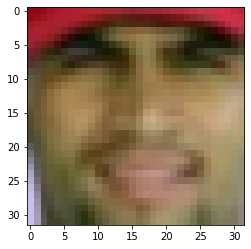

In [0]:
img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)

cuda = True if torch.cuda.is_available() else False 

os.makedirs(outputdir, exist_ok=True)

randomseed = random.randint(1, 10000)
random.seed(randomseed)
torch.manual_seed(randomseed)

# preprocessing for mnist, lsun, cifar10
if dataset_name == 'mnist': 
	dataset = datasets.MNIST(root = dataroot, train=True,download=True, 
		transform=transforms.Compose([transforms.Resize(IMG_SIZE), 
			transforms.ToTensor(), 
			transforms.Normalize((0.5,), (0.5,))]))

elif dataset_name == 'lsun': 
	dataset = datasets.LSUN(root = dataroot, train=True,download=True, 
		transform=transforms.Compose([transforms.Resize(IMG_SIZE), 
			transforms.CenterCrop(IMG_SIZE),
			transforms.ToTensor(), 
			transforms.Normalize((0.5,), (0.5,))]))

elif dataset_name == 'cifar10':  
	dataset = datasets.CIFAR10(root = dataroot, train=True,download=True, 
		transform=transforms.Compose([transforms.Resize(IMG_SIZE), 
			transforms.ToTensor(), 
			transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
 
elif dataset_name == 'celeb': 
	dataset = datasets.CelebA(root = dataroot, split='train',download=False, target_type='attr', 
		transform=transforms.Compose([
			#transforms.Resize((IMG_SIZE*2, IMG_SIZE)), 
		  transforms.CenterCrop(IMG_SIZE*3),
			transforms.Resize((IMG_SIZE, IMG_SIZE)), 
			transforms.ToTensor(), 
			transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

elif dataset_name == 'lfwcrop': 
	dataset = LFWCrop(lfwroot,pca_components=0.70, transform=transforms.Compose([   #, pca_components=0.70
			# transforms.Resize((IMG_SIZE*2, IMG_SIZE)), 
			transforms.Resize((IMG_SIZE, IMG_SIZE)), 
			transforms.ToTensor()
			# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
	 ]))

assert dataset
X, labels = dataset.__getitem__(200)
print("labels are of type" + str(type(labels)))
plt.imshow(X.permute(1, 2, 0))
print("Attribute list for shown image", labels)
print("Number of images", len(dataset))

# il train contiene 162.000 immagini circa. Ne analizziamo n_sample scelte randomicamente
n_sample = dataset.__len__()
train_indices = (np.random.randint(0, len(dataset), n_sample))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_indices)) # senza il sampler mettere shuffle=True

**Parameter Inizialization**

In [0]:
# weight initialization
def init_weights(m): 
	if type(m)==nn.Linear:
		torch.nn.init.xavier_uniform_(m.weight)
		m.bias.data.fill_(0.01)
	
# Building Generator 
generator = Generator(N_CLASSES, LAT_DIM, BATCH_SIZE, dataset_name, img_shape)
# gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lrate, betas=(beta, beta1))
gen_optimizer = optim.SGD(generator.parameters(), lr=LR, momentum=0.9, weight_decay=5e-5)
generator.load_state_dict(torch.load("%sgenerator.pth" % PATH_g))

# Building Discriminator  
discriminator = Discriminator(N_CLASSES, LAT_DIM, BATCH_SIZE, img_shape, dataset_name)
discriminator.load_state_dict(torch.load("%sdiscriminator.pth" % PATH_d))
#discriminator.apply(init_weights)
# d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lrate, betas=(beta, beta1))
d_optimizer = optim.SGD(discriminator.parameters(), lr=LR, momentum=0.7, weight_decay=5e-5)

a_loss = torch.nn.BCELoss() # Loss functions 

# Labels 
real_label = 0.9
fake_label = 0.0

FT = torch.LongTensor
FT_a = torch.FloatTensor

if cuda: 
	generator.cuda()
	discriminator.cuda()
	a_loss.cuda()
	FT = torch.cuda.LongTensor
	FT_a = torch.cuda.FloatTensor


**Training**

In [0]:
 fixed_noise=Variable(FT_a(np.random.normal(0, 1, (64, LAT_DIM))))
 imgs, labels=next(iter(dataloader))
 fixed_labels= Variable(labels[0:64].type(FT_a))

 for epoch in range(1062,EPOCHS): 
	for i, (imgs, labels) in enumerate(dataloader): 
		batch_size = imgs.shape[0]
		
		# convert img, labels into proper form 
		imgs = Variable(imgs.type(FT_a))
		labels = Variable(labels.type(FT_a))
	
		# creating real and fake tensors of labels 
		reall = Variable(FT_a(batch_size, 1).fill_(real_label)) 		# label delle immagini reali per il discriminatore
		f_label = Variable(FT_a(batch_size, 1).fill_(fake_label)) 	# label delle immagini fake per il discriminatore

		# initializing gradient
		gen_optimizer.zero_grad() 
		d_optimizer.zero_grad()

		#### TRAINING DISCRIMINATOR ####
		noise = Variable(FT_a(np.random.normal(0, 1, (batch_size, LAT_DIM)))) # noise ha dimensione imgs.shape[0]xlatentdim imgs dovrebbero essere 64 foto (dimensione di un batch) x 100 pixel ogni foto?
		## Prima generiamo le immagini false tramite il generatore

		gen_labels = Variable(FT(np.random.randint(0, N_CLASSES, batch_size))) # sceglie dei numeri a caso da generare per le 64 immagini
		if dataset_name == 'lfwcrop':
			 gen_labels =labels
		gen_imgs = generator(noise, gen_labels, batch_size) # chiama il generatore passandogli il noise e le labels delle immagini che si aspetta vengano generati

		## Facciamo il training con le sole immagini vere e poi facciamo backward
		d_optimizer.zero_grad()

		# Loss for real images and labels 
		validity_real = discriminator(imgs, labels, batch_size) 	# fai il training usando le immagini vere
		d_real_loss = a_loss(validity_real, reall) 		# quante immagini vere sono state riconosciute come tali?

		d_real_loss.backward()
	
		## Facciamo il training con le sole immagini false e facciamo backward
		# Loss for fake images and labels 
		validity_fake = discriminator(gen_imgs.detach(), gen_labels, batch_size) # quante immagini false ha riconosciuto?
		d_fake_loss = a_loss(validity_fake, f_label)
	
		d_fake_loss.backward()

		# Total discriminator loss 
		d_loss = (d_fake_loss + d_real_loss) # fai una media dell'errore su vere e su false e usa questo nel backward

		# calculates discriminator gradients
		#d_loss.backward()
		d_optimizer.step()
			
		#### TRAINING GENERATOR ####
		# Ability for discriminator to discern the real v generated images 
		validity = discriminator(gen_imgs, gen_labels, batch_size)   # fai il train del discriminator sulle immagini false
		
		# Generative loss function 
		g_loss = a_loss(validity, reall)  # loss in base a quante immagini il discriminatore ha visto come reali (validity) 

		# Gradients 
		g_loss.backward()
		gen_optimizer.step()

	if epoch % 50 == 0: 
		fake = generator(fixed_noise, fixed_labels, 64)
		vutils.save_image(fake.detach(), '%sfake_samples_epoch_%03d.png' % (outputdir, epoch), normalize=True)
	
	print("[Epoch: %d/%d]" "[D loss: %f]" "[G loss: %f]" % (epoch+1, EPOCHS, d_loss.item(), g_loss.item()))
	
	# checkpoints 
	torch.save(generator.state_dict(), '%s/generator.pth' % (outputdir))
	torch.save(discriminator.state_dict(), '%s/discriminator.pth' % (outputdir))


[Epoch: 1063/2000][D loss: 1.203470][G loss: 1.236098]
[Epoch: 1064/2000][D loss: 1.060650][G loss: 1.451243]
[Epoch: 1065/2000][D loss: 1.071026][G loss: 1.266758]
[Epoch: 1066/2000][D loss: 1.067706][G loss: 1.331660]
[Epoch: 1067/2000][D loss: 0.994223][G loss: 1.605243]
[Epoch: 1068/2000][D loss: 1.067486][G loss: 1.270620]
[Epoch: 1069/2000][D loss: 1.109545][G loss: 1.285004]
[Epoch: 1070/2000][D loss: 1.006118][G loss: 1.323966]
[Epoch: 1071/2000][D loss: 1.008310][G loss: 1.487800]
[Epoch: 1072/2000][D loss: 1.090077][G loss: 1.541697]
[Epoch: 1073/2000][D loss: 1.068514][G loss: 1.296158]
[Epoch: 1074/2000][D loss: 1.032225][G loss: 1.278126]
[Epoch: 1075/2000][D loss: 1.138337][G loss: 1.376342]
[Epoch: 1076/2000][D loss: 0.996176][G loss: 1.346431]
[Epoch: 1077/2000][D loss: 1.192698][G loss: 1.236304]
[Epoch: 1078/2000][D loss: 1.090604][G loss: 1.452981]
[Epoch: 1079/2000][D loss: 0.966226][G loss: 1.405291]
[Epoch: 1080/2000][D loss: 1.024380][G loss: 1.356089]
[Epoch: 10

In [0]:
generator.load_state_dict(torch.load("%sgenerator.pth" % (outputdir)))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 32, 32])
tensor([ 1.6870,  2.3160, -0.8239, -1.4251, -1.1007, -0.9700, -1.8032, -0.9561,
         0.5468, -1.8568, -0.7860], device='cuda:0')
tensor([ 1.6870,  2.3160, -0.8239, -1.4251, -1.1007, -0.9700,  5.5000, -0.9561,
         0.5468, -1.8568, -0.7860], device='cuda:0')
torch.Size([1, 3, 32, 32])
tensor([ 1.6870,  2.3160, -0.8239, -1.4251, -1.1007, -0.9700,  4.0000, -0.9561,
         0.5468, -1.8568, -0.7860], device='cuda:0')
torch.Size([1, 3, 32, 32])
tensor([ 1.6870,  2.3160, -0.8239, -1.4251, -1.1007, -0.9700,  2.5000, -0.9561,
         0.5468, -1.8568, -0.7860], device='cuda:0')
torch.Size([1, 3, 32, 32])
tensor([ 1.6870,  2.3160, -0.8239, -1.4251, -1.1007, -0.9700,  1.0000, -0.9561,
         0.5468, -1.8568, -0.7860], device='cuda:0')
torch.Size([1, 3, 32, 32])
tensor([ 1.6870,  2.3160, -0.8239, -1.4251, -1.1007, -0.9700, -0.5000, -0.9561,
         0.5468, -1.8568, -0.7860], device='cuda:0')
torch.Size([1, 3, 32, 32])
tensor([ 1.6870,  2.3160, -0.8239, -1.42

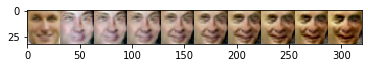

In [0]:
X, gen_labels = dataset.__getitem__(3)
gen_labels = Variable(gen_labels.type(FT_a))
noise = Variable(FT_a(np.random.normal(0, 1, (LAT_DIM, ))))
gen_imgs = X
gen_imgs = Variable(gen_imgs.type(FT_a))
gen_imgs = gen_imgs.view(1, 3, 32, 32)
print(gen_imgs.shape)
print(gen_labels)


for i in range(1,10, 1):
    
    gen_labels[6]=7-1.5*i # from female to male (male is negative)
    #gen_labels[3]=4-0.8*i # from not smile to smile (smile is negative)
    #gen_labels[10]=4-0.8*i    #from mouth closed to non mouth closed(mouth closed is negative)
    
    #gen_labels[1]=-7+1.5*i
    #gen_labels[2]=-7+i
    #gen_labels[3] = -7 + i*1.4
    #gen_labels[10] = -5 + i*1
    #gen_labels[6] = -5 + i
   # gen_labels[7] = 2 - i*0.4
    #gen_labels[8] = 3 - i*0.6
    #gen_labels[33]=7-i*1.4

    print(gen_labels)
    img = generator(noise, gen_labels, 1)
    print(img.shape)
    gen_imgs = torch.cat((gen_imgs, img), -1)
    vutils.save_image(gen_imgs, 'final_gen_sample_%d.png' % i, normalize=True)

    


plt.imshow(X.permute(1, 2, 0))
plt.imshow(gen_imgs.cpu().detach()[0].permute(1,2,0))

**Doing KNN test for overfitting**

In [0]:
IMG_SIZE = 16
k=1 

# Using Knn to find nearest Neighbor
dataset2 = LFWCrop(lfwroot, transform=transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), 
    transforms.Grayscale(),
    transforms.ToTensor()
]))

X_train = []
y_train = []


for i in range(0, dataset2.__len__()):
    image, _= dataset2.__getitem__(i)
    image = image.flatten().numpy()

    X_train.append(image)

nnCls = NearestNeighbors(n_neighbors=k, p=1)
nnCls.fit(X_train)

def findKNNeighbors(myImage, nnCls=nnCls, img_size = 32):

    distances, indeces = nnCls.kneighbors([myImage.flatten()])

    for index in indeces[0]:
        nearImage, _ = dataset.__getitem__(index)

    return indeces[0]

noise = Variable(FT_a(np.random.normal(0, 1, (LAT_DIM, ))))

# we consider "overfitted" a generated image that has as nearest neighbor
# the image from which the label that generated it was taken from

overfitted = 0
print("Calculating overfitting:")
  
for i in range(dataset.__len__()):
  origImg, label = dataset.__getitem__(i)
  
  label = Variable(label.type(FT_a))
  # generate false image
  gen_img = generator(noise, label, 1)
  gen_img = gen_img.view(32, 32, 3).cpu()
  gen_transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize((IMG_SIZE, IMG_SIZE)), 
          transforms.Grayscale(),
          transforms.ToTensor()
      ])
  
  gen_img = gen_transform(gen_img)
  nearest = findKNNeighbors(gen_img.numpy(), img_size=IMG_SIZE)
  
  
  if nearest[0] == i: 
    overfitted += 1
  else:
    print("Percentage: %f" % (i/dataset.__len__()), end = '\r')

# how many images overfitted in the whole dataset?
overfit_ratio = overfitted/dataset.__len__()
print("Overfit Ratio = %f" % (overfit_ratio))








In [0]:
print(overfitted)

In [0]:
generator.load_state_dict(torch.load(PATH_g))
generator.eval()

discriminator.load_state_dict(torch.load(PATH_d))
discriminator.eval()

gen_labels = Variable(FT_a(2*np.random.standard_normal(size=(BATCH_SIZE, N_CLASSES))))
noise = Variable(FT_a(np.random.normal(0, 1, (BATCH_SIZE, LAT_DIM))))

gen_imgs = generator(noise, gen_labels, BATCH_SIZE)
vutils.save_image(gen_imgs, '%s/final_gen_sample.png' % outputdir)